# Inicializando acesso ao Google Drive

In [ ]:
'''
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get -qq install -y software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get -qq update 2>&1 > /dev/null
!apt-get -y -qq install google-drive-ocamlfuse fuse
print('Installed')
'''

In [ ]:
'''
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/
'''

# Atividade 03: Classificador Softmax

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Esta atividade é análoga a feita anteriormente sobre SVM. Você irá:

- implementar uma **função de perda** (**loss function**) de forma completamente paralela para o classificador Softmax
- implementar a expressão para seu **gradiente analítico** de forma completamente paralela
- **verificar sua implementação** utilizando gradiente numérico
- usar um conjunto de validação para **ajustar a taxa de aprendizado e regularização**
- **otimizar** a função de perda com **SGD**
- **visualizar** os pesos finais que foram obtidos


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
#PATH_DIRECTORY = 'drive/Colab Notebooks/i2dl/tp1'
#os.chdir(PATH_DIRECTORY)
from dl.data_utils import load_CIFAR10
from __future__ import print_function

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Carrega CIFAR-10 dataset a partit do disco e realiza preprocessamento para preparar
    os dados para o classificador linear. Estes são os mesmos passos usados para o modelo
    SVM, porém condensado em uma única função.  
    """
    # Carregga os dados CIFAR-10 brutos
    cifar10_dir = 'dl/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subdivide os dados em conjuntos
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessamento: redimensiona as imagens de matrizes para vetores
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normaliza os dados: subtrai a imagem média
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # Acrescenta uma dimensão (viés/bias) e transforma em colunas
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Usar a função definida acmina para obter os dados.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Classificador Softmax

Seu código para está seção será todo escrito dentro do arquivo `dl/classifiers/softmax.py`.


In [4]:
# Primeiramente, implemente a versão ingênua da função de perda softmax usando laços aninhados.
# Abra o arquivo dl/classifiers/softmax.py e implemente a função softmax_loss_naive.

from dl.classifiers.softmax import softmax_loss_naive
import time

# Produz uma matrix pesos aleatórios e a usa para calcular a perda. 
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Apenas como uma verificação, o valor de perda deve ser algo próximo a -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.354322
sanity check: 2.302585


## Pergunta 01:
Por que se deve esperar que a perda calculada seja próxima de -log(0.1)? Explique brevemente.


**Sua Resposta:** 

*Como W é selecionado de forma aleatória, a chance de da classe ser a desejada é 1/10. A perda será dada pelo seu log, correspondente a -log(0.1).*

In [10]:
# Complete a implementação da função softmax_loss_naive, acrescentando uma
# versão (ingênua) de cálculo do gradiente que utilize laços aninhados. 
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Como foi feito para o SVM, use a estimativa numérica do gradiente como
# ferramenta de verificação e depuração. 
# O valor do gradiente numérico deve ser próximo do obtido analiticamente.
from dl.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Similar ao SVM, faça outra verificação utilização um valor de regularização não nulo
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.446290 analytic: -2.446290, relative error: 1.645762e-08
numerical: -0.803589 analytic: -0.803589, relative error: 5.395035e-08
numerical: -0.230350 analytic: -0.230350, relative error: 4.181081e-08
numerical: -2.868085 analytic: -2.868085, relative error: 1.490039e-08
numerical: 2.763169 analytic: 2.763169, relative error: 1.034115e-08
numerical: -2.746387 analytic: -2.746387, relative error: 1.736095e-08
numerical: 0.544372 analytic: 0.544372, relative error: 1.181103e-07
numerical: -0.552440 analytic: -0.552440, relative error: 1.764089e-08
numerical: -2.226342 analytic: -2.226342, relative error: 4.378324e-08
numerical: 0.577474 analytic: 0.577474, relative error: 1.348942e-07
numerical: 1.585210 analytic: 1.585902, relative error: 2.182269e-04
numerical: -0.587146 analytic: -0.579146, relative error: 6.859387e-03
numerical: -2.348643 analytic: -2.349714, relative error: 2.280990e-04
numerical: -0.849539 analytic: -0.856201, relative error: 3.905586e-03
numerical: 2.2

In [33]:
# Agora que se tem uma versão básica de para cálculo da função de perda e de seu gradiente,
# você deve implementar uma versão vetorial/paralela na função softmax_loss_vectorized.

# Novamente, os valores devem coincidir porém a versão vetorial deve ser mais rápida.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Como para o SVM, utiliza-se a norma de Frobenius para comparar as duas versões
# de gradiente.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.354322e+00 computed in 0.204641s
vectorized loss: 2.354322e+00 computed in 0.007383s
Loss difference: 0.000000
Gradient difference: 0.000000


In [35]:
# Utilize o conjunto de validação para ajustar os hiperparâmetros (taxa de 
# aprendizado e regularização). Você deve experimentar diferentes intervalos
# para ambos. Se você proceder corretamente deve ser capaz de obter uma acurácia
# acima de 0.35 no conjunto de validação.

from dl.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Escrever o código que escolhe os melhores hiperparâmetros usando o conjunto  #
# de validação. Deve ser muito similar ao código feito para o SVM.             #
# Além disso, deve-se armazenar a melhor acurácia de validação em best_val     #
# e o objeto Softmax que obteve esse resultado em best_softmax.                #
################################################################################
n_iters = 1000

softmax = Softmax()
best_train = 0
best_lr = 0
best_reg = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=n_iters, verbose=False)
        
        #predict
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        
        #validate
        cur_train = np.mean(y_train == y_train_pred)
        cur_valid = np.mean(y_val == y_val_pred)
        
        #save results
        results[(lr, reg)] = (cur_train, cur_valid)
        
        #print
        print('lr: %e reg: %e train: %f valid: %f' % (lr, reg, cur_train, cur_valid))
        
        if cur_valid > best_val:
            best_val = cur_valid
            best_train = cur_train
            best_lr = lr
            best_reg = reg
            best_softmax = softmax #salva svm para uso posterior
            
################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################
    
# Exibe os resultados.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr: 1.000000e-07 reg: 2.500000e+04 train: 0.339939 valid: 0.341000
lr: 1.000000e-07 reg: 5.000000e+04 train: 0.326306 valid: 0.336000
lr: 5.000000e-07 reg: 2.500000e+04 train: 0.344245 valid: 0.365000
lr: 5.000000e-07 reg: 5.000000e+04 train: 0.327612 valid: 0.344000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.339939 val accuracy: 0.341000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.326306 val accuracy: 0.336000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.344245 val accuracy: 0.365000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.327612 val accuracy: 0.344000
best validation accuracy achieved during cross-validation: 0.365000


In [36]:
# Avalia o melhor modelo Softmax no conjunto de teste
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


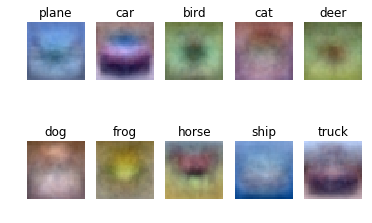

In [37]:
# Visualiza os pesos obtidos para cada classe.
w = best_softmax.W[:-1,:] # remove o viés/bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Redimensiona os pesos para o intervalo entre 0 e 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])